In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [19]:
import utils.wtn_calc as calc

In [2]:
import utils.metrics as utils_metrics

In [3]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [4]:
data_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
data_table = list(data_table)
data_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [5]:
train_rows = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows:
    if 'text' in row:
        del row['text']

In [6]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [7]:
Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(10, True, 'toloka')
context

Context(max_num_answers=10, for_fitting=True, platform='toloka')

In [8]:
train_proc = Processor(train_rows, context)
test_proc = Processor(test_rows, context)

for row in train_rows:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc.rows.append(value)

for row in test_rows:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc.rows.append(value)

In [9]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [10]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != "", -x[0].count('?')))
#     if text != "" and text_rate >= 2:
    if text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [11]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    total_recall = 0
    total_items = 0
    correct = 0
    cost = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        _, e, l = calc.calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        recall, _, _ = calc.calculate_word_recall(row["text"], hyp)
        total_recall += recall
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    total_recall /= total_items
    cost = cost / total_items
    if print_:
        print("Recall: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            total_recall, wer, accuracy, cost
        ))
    return total_recall, wer, accuracy, cost

In [12]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [13]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [14]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [15]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, max_cost=10, cluster_refernces=None, 
                               print_=True):
    errors = 0
    total_length = 0
    total_recall = 0
    total_items = 0
    correct = 0
    cost = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or hyp.confidence < treshhold:
            continue
        hyp = hyp.text
        _, e, l = calc.calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        recall, _, _ = calc.calculate_word_recall(row["text"], hyp)
        total_recall += recall
        total_length += l
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    total_recall /= total_items
    cost = cost / total_items
    if print_:
        print("Recall: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            total_recall, wer, accuracy, cost
        ))
    return total_recall, wer, accuracy, cost

In [16]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
#                 if text == "":
#                     conf = 0
#                     text = None
#                 elif score < treshhold:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [17]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              treshhold,
                                              cluster_refernces, 
                                              print_)

In [21]:
import matplotlib.pyplot as plt

In [22]:
train_rows_q = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows_q = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows_q:
    if 'text' in row:
        del row['text']

In [23]:
train_proc_q = Processor(train_rows_q, context)
test_proc_q = Processor(test_rows_q, context)

for row in train_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc_q.rows.append(value)

for row in test_rows_q:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc_q.rows.append(value)

In [ ]:
train_features_q = train_proc_q.extract_features()

In [51]:
import dill

In [52]:
with open('pickled/train_features_q.dill', 'wb') as file:
    dill.dump(train_features_q, file)

In [53]:
with open('pickled/test_features_q.dill', 'wb') as file:
    dill.dump(test_features_q, file)

In [ ]:
print('test started')
test_features_q = test_proc_q.extract_features()

In [ ]:
X_train_q, Y_train_q = convert_to_array(train_features_q)

In [ ]:
clf_q = CatBoostClassifier(iterations=19000, depth=7, thread_count=30, random_seed=42)
clf_q.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("new wer model is fitted\n")

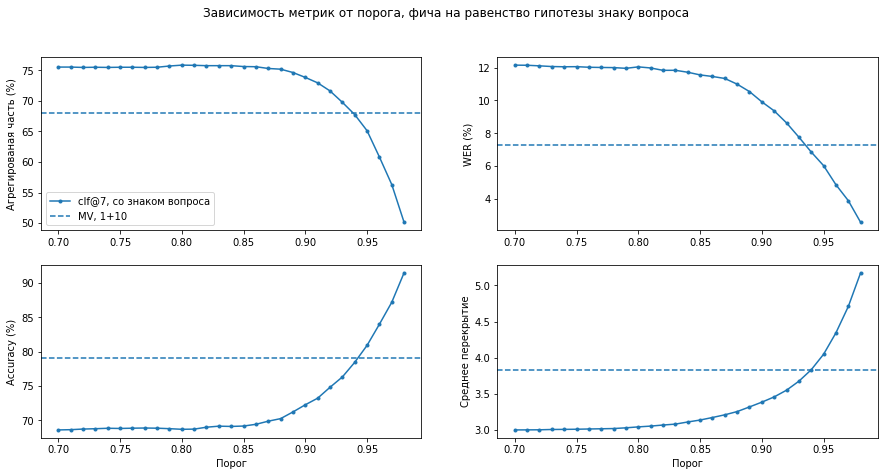

In [33]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, фича на равенство гипотезы знаку вопроса')
plt.subplot(221)
# plt.plot(scores_clf_test_new_feature[:, 0], 
#          scores_clf_test_new_feature[:, 1] * 100, 
#          ".-", 
#          label="clf@7, новые ГП")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 1] * 100, 
         ".-", 
         label="clf@7, со знаком вопроса")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, 1+10")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
# plt.plot(scores_clf_test_new_feature[:, 0], 
#          scores_clf_test_new_feature[:, 2] * 100, 
#          ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
# plt.plot(scores_clf_test_new_feature[:, 0], 
#          scores_clf_test_new_feature[:, 3] * 100, 
#          ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
# plt.plot(scores_clf_test_new_feature[:, 0], 
#          scores_clf_test_new_feature[:, 4], 
#          ".-")
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_question_sign_assistant.png")
plt.show()

In [34]:
import pickle

In [36]:
with open('new_metrics_solo_assistant.pickle', 'rb') as f:
    metrics_loaded = pickle.load(f)
metrics_loaded

array([[0.8       , 0.95539608, 0.13177556, 3.04475043],
       [0.81      , 0.95559898, 0.13130721, 3.05565118],
       [0.82      , 0.9541686 , 0.12982919, 3.07028112],
       [0.83      , 0.95453   , 0.12946265, 3.0831899 ],
       [0.84      , 0.95452073, 0.12809796, 3.1124498 ],
       [0.85      , 0.95218814, 0.1267616 , 3.1394148 ],
       [0.86      , 0.95252349, 0.12522939, 3.17441193],
       [0.87      , 0.95014641, 0.1234077 , 3.21170396],
       [0.88      , 0.94898656, 0.12064264, 3.25645439],
       [0.89      , 0.94553584, 0.11641857, 3.32071142],
       [0.9       , 0.93799655, 0.11070387, 3.38668962],
       [0.91      , 0.93200009, 0.10418717, 3.45926563],
       [0.92      , 0.92094274, 0.09641152, 3.55220884],
       [0.93      , 0.9015056 , 0.0869153 , 3.67641997],
       [0.94      , 0.88315606, 0.07613219, 3.83476764],
       [0.95      , 0.85513543, 0.06587186, 4.04905336],
       [0.96      , 0.80601457, 0.05400616, 4.34538153],
       [0.97      , 0.75627608,

In [37]:
import seaborn as sns
sns.set(style="whitegrid")

In [28]:
preaggregated = preaggregate_with_clf(test_features_q, clf_q)

In [29]:
preaggregated['1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus']

{1: [('', 0.678010134822878)],
 2: [('', 0.8812058476980162)],
 3: [('', 0.9304909564468234)],
 4: [('', 0.9520213571597353)],
 5: [('', 0.9666642123647229)],
 6: [('', 0.9879260899568811)],
 7: [('', 0.9867620990253291)],
 8: [('', 0.9829812412150699)],
 9: [('', 0.9879957352825978)],
 10: [('', 0.9895018590776006)]}

In [30]:
from functools import partial

In [31]:
scores_clf_test_q_ = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_,
                                                       preaggregated=preaggregated))
    scores_clf_test_q_.append((treshhold, *metrics))
scores_clf_test_q_ = np.array(scores_clf_test_q_)

0.8
Recall: 95.4368%
WER: 13.1409%
Mean overlap: 3.05
0.81
Recall: 95.4388%
WER: 13.1024%
Mean overlap: 3.062
0.8200000000000001
Recall: 95.3983%
WER: 13.0970%
Mean overlap: 3.075
0.8300000000000001
Recall: 95.3906%
WER: 12.9507%
Mean overlap: 3.1
0.8400000000000001
Recall: 95.3293%
WER: 12.8372%
Mean overlap: 3.125
0.85
Recall: 95.2165%
WER: 12.7138%
Mean overlap: 3.154
0.86
Recall: 95.2711%
WER: 12.5376%
Mean overlap: 3.19
0.87
Recall: 95.1182%
WER: 12.2441%
Mean overlap: 3.225
0.88
Recall: 94.9746%
WER: 11.9761%
Mean overlap: 3.267
0.89
Recall: 94.3865%
WER: 11.5590%
Mean overlap: 3.338
0.9
Recall: 93.9334%
WER: 11.0272%
Mean overlap: 3.397
0.91
Recall: 93.0286%
WER: 10.2697%
Mean overlap: 3.485
0.92
Recall: 91.6530%
WER: 9.4598%
Mean overlap: 3.581
0.9299999999999999
Recall: 90.1837%
WER: 8.6288%
Mean overlap: 3.706
0.94
Recall: 88.1111%
WER: 7.6148%
Mean overlap: 3.849
0.95
Recall: 85.2225%
WER: 6.5242%
Mean overlap: 4.078
0.96
Recall: 80.5344%
WER: 5.4183%
Mean overlap: 4.37
0.97

NameError: name 'scores_clf_test_q' is not defined

In [38]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 88.0484%
WER: 13.3954%
Mean overlap: 3.833


In [39]:
with open('base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.98      , 0.86047811, 0.06822048, 4.00143431])

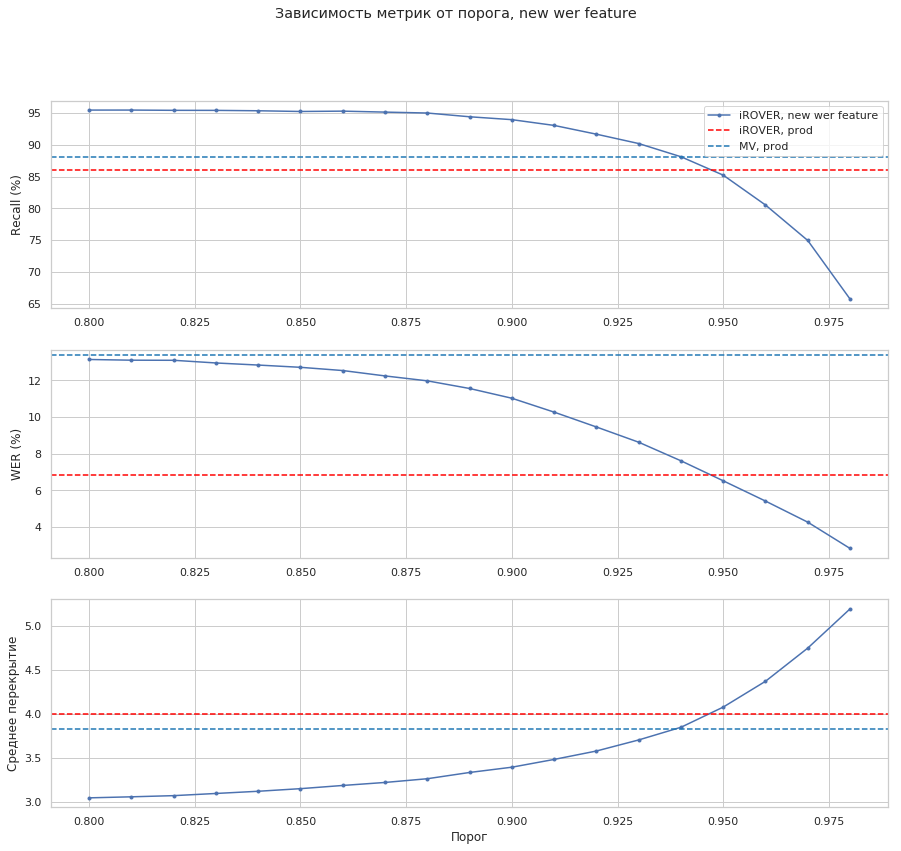

In [43]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от порога, new wer feature')
plt.subplot(311)
plt.plot(scores_clf_test_q_[:, 0], 
         scores_clf_test_q_[:, 1] * 100, 
         ".-", 
         label="iROVER, new wer feature")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.legend()
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_clf_test_q_[:, 0], 
         scores_clf_test_q_[:, 2] * 100, 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_test_q_[:, 0], 
         scores_clf_test_q_[:, 3], 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("new_metrics_new_wer_feature.png")
plt.show()

**Значимого прироста не дало**